## 0. Set up

In [ ]:
! pip install transformers datasets evaluate scikit-learn
! pip install accelerate -U

In [ ]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
import pandas as pd
from transformers import AutoTokenizer
from datasets import load_dataset
from datasets import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

## 1. Load dataset
I will use the HC3 (Human ChatGPT Comparison Corpus) dataset from the 🤗 Datasets library.

In [ ]:
ds = load_dataset("hello-simpleai/hc3", data_files=['all.jsonl' ])
print(f"Train dataset size: {len(ds['train'])}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train dataset size: 24322


There are five fields in this dataset:
  - question
  - human_answers (several)
  - chatgpt_answers (several)
  - index
  - source

*** There is only train set, therefore test set should be seperated from the train set manually.

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'human_answers', 'chatgpt_answers', 'index', 'source'],
        num_rows: 24322
    })
})

In [ ]:
ds['train'][3]['human_answers'][0]

"You ca n't just go around assassinating the leaders of countries you do nt like ! The international condemnation would be brutal . Even though noone likes Kim Jong - Un , and everyone thinks North Korea is pretty shitty to its citizens , if say the US were to send agents over ( and do n't think they are n't capable of it ) and they got caught .... every country , every world leader would be a potential target . Who 's next ... Castro ? Angela Merkel ? Anyways , rumour has it that he 's ultra paranoid about exactly that and travels around in tanks and armoured trains that make Limo 1 look like a tonka toy ."

## 2. Preprocess
The next step is to load a tokenizer to preprocess the text field. A tokenizer converts text to a sequence of tokens and creates numerical representation.

In [ ]:
# test tokenizer

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
text = "Hello everyone!"
vocab = {v:k for k,v in roberta_tokenizer.vocab.items()}

print([(id, vocab[id]) for id in roberta_tokenizer(text)['input_ids']])
print([(id, vocab[id]) for id in roberta_tokenizer(ds['train'][3]['human_answers'][0])['input_ids']])

[(0, '<s>'), (31414, 'Hello'), (961, 'Ġeveryone'), (328, '!'), (2, '</s>')]
[(0, '<s>'), (1185, 'You'), (6056, 'Ġca'), (295, 'Ġn'), (75, "'t"), (95, 'Ġjust'), (213, 'Ġgo'), (198, 'Ġaround'), (39257, 'Ġassass'), (15647, 'inating'), (5, 'Ġthe'), (917, 'Ġleaders'), (9, 'Ġof'), (749, 'Ġcountries'), (47, 'Ġyou'), (109, 'Ġdo'), (295, 'Ġn'), (90, 't'), (101, 'Ġlike'), (27785, 'Ġ!'), (20, 'ĠThe'), (758, 'Ġinternational'), (19973, 'Ġcondemnation'), (74, 'Ġwould'), (28, 'Ġbe'), (8513, 'Ġbrutal'), (479, 'Ġ.'), (1648, 'ĠEven'), (600, 'Ġthough'), (117, 'Ġno'), (1264, 'one'), (3829, 'Ġlikes'), (1636, 'ĠKim'), (6465, 'ĠJong'), (111, 'Ġ-'), (1890, 'ĠUn'), (2156, 'Ġ,'), (8, 'Ġand'), (961, 'Ġeveryone'), (4265, 'Ġthinks'), (369, 'ĠNorth'), (1101, 'ĠKorea'), (16, 'Ġis'), (1256, 'Ġpretty'), (43816, 'Ġshitty'), (7, 'Ġto'), (63, 'Ġits'), (2286, 'Ġcitizens'), (2156, 'Ġ,'), (114, 'Ġif'), (224, 'Ġsay'), (5, 'Ġthe'), (382, 'ĠUS'), (58, 'Ġwere'), (7, 'Ġto'), (2142, 'Ġsend'), (3525, 'Ġagents'), (81, 'Ġover'), (36,

In [ ]:
def human_answer_tokenizer(example, answer_type):
    temp_dict = roberta_tokenizer(example[answer_type][0], truncation=True, padding='max_length')
    temp_dict['label'] = 0
    return temp_dict

In [ ]:
tokenized_human_answers = ds['train'].map(lambda x: human_answer_tokenizer(x, 'human_answers'), batched=False)


Map:   0%|          | 0/24322 [00:00<?, ? examples/s]

In [ ]:
tokenized_human_answers = tokenized_human_answers.remove_columns(['chatgpt_answers'])
tokenized_human_answers = tokenized_human_answers.rename_column('human_answers', 'answer')


In [ ]:
tokenized_human_answers_df = pd.DataFrame(tokenized_human_answers)

In [ ]:
tokenized_human_answers_df.head()

,question,answer,index,source,input_ids,attention_mask,label
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",NaN,reddit_eli5,"[0, 34480, 89, 32, 171, 6363, 9, 22, 2700, 447...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,NaN,reddit_eli5,"[0, 29, 3967, 16, 205, 13, 45, 8180, 11, 512, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,NaN,reddit_eli5,"[0, 133, 169, 24, 1364, 16, 14, 793, 1012, 449...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,NaN,reddit_eli5,"[0, 1185, 6056, 295, 75, 95, 213, 198, 39257, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,NaN,reddit_eli5,"[0, 38576, 154, 7, 3549, 5, 15328, 66, 9, 1841...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0


In [ ]:
print(tokenized_human_answers_df.loc[0]['input_ids'].count(1))
print(tokenized_human_answers_df.loc[0]['attention_mask'].count(0))

371
371


In [ ]:
question_list = []
chatgpt_answer_list = []
index_list = []
source_list = []
input_ids_list = []
attention_mask_list = []
label_list = []

for sample in ds['train']:

  # some of the question does not have answer.
  if len(sample['chatgpt_answers'])!=0:
    one_chatgpt_answer = sample['chatgpt_answers'][0]

    question_list.append(sample['question'])
    chatgpt_answer_list.append([one_chatgpt_answer])
    index_list.append(sample['index'])
    source_list.append(sample['source'])
    input_ids_list.append(roberta_tokenizer(one_chatgpt_answer, truncation=True)['input_ids'])
    attention_mask_list.append(roberta_tokenizer(one_chatgpt_answer, truncation=True)['attention_mask'])
    label_list.append(1)

In [ ]:

tokenized_chatgpt_answers_df = pd.DataFrame.from_dict({'question':question_list, 'answer':chatgpt_answer_list, 'index':index_list, \
                                                       'source':source_list, 'input_ids':input_ids_list, 'attention_mask':attention_mask_list, \
                                                      'label':label_list})

In [ ]:
tokenized_chatgpt_answers_df.head()

,question,answer,index,source,input_ids,attention_mask,label
0,"Why is every book I hear about a "" NY Times # ...",[There are many different best seller lists th...,NaN,reddit_eli5,"[0, 970, 32, 171, 430, 275, 15689, 8204, 14, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,"If salt is so bad for cars , why do we use it ...",[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5,"[0, 44095, 16, 341, 15, 3197, 7, 244, 20147, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,Why do we still have SD TV channels when HD lo...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5,"[0, 970, 32, 10, 367, 2188, 596, 52, 202, 33, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,Why has nobody assassinated Kim Jong - un He i...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5,"[0, 243, 16, 3489, 45, 9796, 50, 13557, 7, 715...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,How was airplane technology able to advance so...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5,"[0, 4993, 5, 5825, 10144, 156, 5, 78, 8852, 25...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [ ]:
length_tokens=[]
for i in tokenized_chatgpt_answers_df.index:
  length_tokens.append(len(tokenized_chatgpt_answers_df.loc[i]['input_ids']))

In [ ]:
max(length_tokens)

512

In [ ]:
def add_token_padding(sample):

  if len(sample)<512:

    token_paddings = [0 for i in range(512-len(sample))]
    return sample + token_paddings

  else:
    return sample

def add_mask_padding(sample):

  if len(sample)<512:

    mask_paddings = [1 for i in range(512-len(sample))]
    return sample + mask_paddings

  else:
    return sample

In [ ]:
tokenized_chatgpt_answers_df['input_ids'] = tokenized_chatgpt_answers_df['input_ids'].map(lambda x: add_token_padding(x))
tokenized_chatgpt_answers_df['attention_mask'] = tokenized_chatgpt_answers_df['attention_mask'].map(lambda x: add_mask_padding(x))

In [ ]:
length_tokens=[]
for i in tokenized_chatgpt_answers_df.index:
  length_tokens.append(len(tokenized_chatgpt_answers_df.loc[i]['input_ids']))

print(set(length_tokens))

{512}


In [ ]:
length_tokens=[]
for i in tokenized_chatgpt_answers_df.index:
  length_tokens.append(len(tokenized_chatgpt_answers_df.loc[i]['attention_mask']))

print(set(length_tokens))

{512}


In [ ]:
combined_df = pd.concat([tokenized_human_answers_df, tokenized_chatgpt_answers_df], ignore_index=True)

In [ ]:
combined_df.head()

,question,answer,index,source,input_ids,attention_mask,label
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",NaN,reddit_eli5,"[0, 34480, 89, 32, 171, 6363, 9, 22, 2700, 447...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,NaN,reddit_eli5,"[0, 29, 3967, 16, 205, 13, 45, 8180, 11, 512, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,NaN,reddit_eli5,"[0, 133, 169, 24, 1364, 16, 14, 793, 1012, 449...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,NaN,reddit_eli5,"[0, 1185, 6056, 295, 75, 95, 213, 198, 39257, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,NaN,reddit_eli5,"[0, 38576, 154, 7, 3549, 5, 15328, 66, 9, 1841...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0


In [ ]:
length_tokens=[]
for i in combined_df.index:
  length_tokens.append(len(combined_df.loc[i]['input_ids']))

print(set(length_tokens))

length_tokens=[]
for i in combined_df.index:
  length_tokens.append(len(combined_df.loc[i]['attention_mask']))

print(set(length_tokens))

{512}
{512}


In [ ]:
print(tokenized_human_answers_df.shape, tokenized_chatgpt_answers_df.shape)
print(combined_df.shape)
combined_df.head()

(24322, 7) (23867, 7)
(48189, 7)


,question,answer,index,source,input_ids,attention_mask,label
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",NaN,reddit_eli5,"[0, 34480, 89, 32, 171, 6363, 9, 22, 2700, 447...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,NaN,reddit_eli5,"[0, 29, 3967, 16, 205, 13, 45, 8180, 11, 512, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,NaN,reddit_eli5,"[0, 133, 169, 24, 1364, 16, 14, 793, 1012, 449...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,NaN,reddit_eli5,"[0, 1185, 6056, 295, 75, 95, 213, 198, 39257, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,NaN,reddit_eli5,"[0, 38576, 154, 7, 3549, 5, 15328, 66, 9, 1841...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0


In [ ]:
tokenized_dataset = Dataset.from_pandas(combined_df)

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(["question", "answer", "index", "source"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

In [ ]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 48189
})

In [ ]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.95)['train'].train_test_split(test_size=0.2)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 482
    })
})

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_dataset['train'], shuffle=True, batch_size=20)
eval_dataloader = DataLoader(tokenized_dataset['test'], batch_size=20)

In [ ]:
id2label = {0: "human", 1: "chatgpt"}
label2id = {"human": 0, "chatgpt": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# This automodel class gives us the model with pretrained weights + a sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2, id2label=id2label, label2id=label2id, hidden_dropout_prob=0.12
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.12, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [ ]:
from tqdm.auto import tqdm
import evaluate

progress_bar = tqdm(range(num_training_steps))

train_loss_list = []
val_loss_list = []


for epoch in range(num_epochs):

    train_loss = 0
    train_acc = 0
    train_total_size = 0

    for batch in train_dataloader:

        train_total_size += len(batch['input_ids'])

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        train_loss+=loss

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)




    val_loss = 0
    val_total_size = 0

    metric = evaluate.load("accuracy")

    for batch in eval_dataloader:

        val_total_size += len(batch['input_ids'])


        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        val_loss+=loss

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])


    print(f'\tTrain Loss: {train_loss/train_total_size} | Val Loss: {val_loss/val_total_size}')

    train_loss_list.append(train_loss/train_total_size)
    val_loss_list.append(val_loss/val_total_size)



  0%|          | 0/1940 [00:00<?, ?it/s]

	Train Loss: 0.002440508920699358 | Val Loss: 4.546650234260596e-05
	Train Loss: 0.0005299684125930071 | Val Loss: 1.7149021005025133e-05
	Train Loss: 0.0004537891654763371 | Val Loss: 7.809452654328197e-05
	Train Loss: 0.00041639659320935607 | Val Loss: 1.5312327377614565e-05
	Train Loss: 0.00030285248067229986 | Val Loss: 1.2393797987897415e-05
	Train Loss: 8.513111424690578e-06 | Val Loss: 5.221949322731234e-06
	Train Loss: 4.407833785080584e-06 | Val Loss: 3.5364485029276693e-06
	Train Loss: 3.1760162073624087e-06 | Val Loss: 2.7049286472902168e-06
	Train Loss: 2.5066121907002525e-06 | Val Loss: 2.2030615127732744e-06
	Train Loss: 2.082899982269737e-06 | Val Loss: 1.8726647112998762e-06
	Train Loss: 1.7928325632965425e-06 | Val Loss: 1.6345389894922846e-06
	Train Loss: 1.5833438737899996e-06 | Val Loss: 1.4593903188142576e-06
	Train Loss: 1.4268103996073478e-06 | Val Loss: 1.3279671975396923e-06
	Train Loss: 1.3062182233625208e-06 | Val Loss: 1.2262210020708153e-06
	Train Loss: 1.2

In [ ]:
test_list = []

for i in val_loss_list:
  test_list.append(float(i))


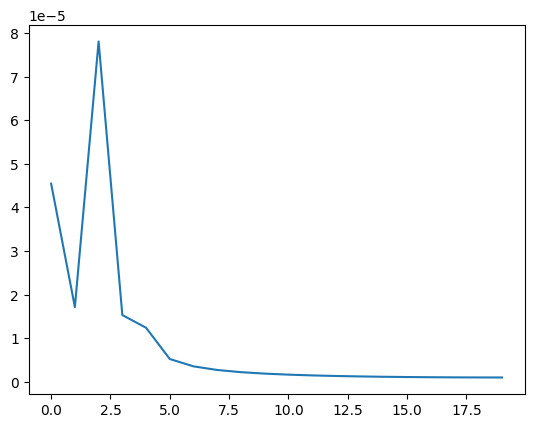

In [ ]:
from matplotlib import pyplot as plt

plt.plot(test_list)

In [86]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2
)

In [87]:
training_args.output_dir

'my_awesome_model'

In [ ]:
from tqdm.auto import tqdm
import evaluate

class CustomTrainer(Trainer):

  def __inner_trainint_loop(self, batch_size=None, num_epochs=None):


    progress_bar = tqdm(range(num_training_steps))

    train_loss_list = []
    val_loss_list = []


    for epoch in range(num_epochs):

        train_loss = 0
        train_acc = 0
        train_total_size = 0

        for batch in train_dataloader:

            train_total_size += len(batch['input_ids'])

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            train_loss+=loss

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)




        val_loss = 0
        val_total_size = 0

        metric = evaluate.load("accuracy")

        for batch in eval_dataloader:

            val_total_size += len(batch['input_ids'])


            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            loss = outputs.loss
            val_loss+=loss

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch["labels"])


        print(f'\tTrain Loss: {train_loss/train_total_size} | Val Loss: {val_loss/val_total_size}')

        train_loss_list.append(train_loss/train_total_size)
        val_loss_list.append(val_loss/val_total_size)

